In [1]:
# * * * * * * * * * * * * * * * *
# Configuration
# * * * * * * * * * * * * * * * *
EXPERIMENT_NUM='1'

DATASET_DIR = '/workspace/datasets'
OUTPUT_DIR = '/workspace/outputs'

DEVICE = "cpu"

LATENT_DIM=4
BATCH_SIZE=200
EPOCHS=100
BETA=0.2
LEARNING_RATE=1e-3
GAMMA=0.1

INPUT_DIM=(1,120)

In [2]:
import os
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchinfo import summary

from lunar_vae import VAE, train, SampleLatentSpace, VisualizeLatentSpace
from utils import (
    CollectStatisticsFromProfilesV1,
    GenerateDensityPlot,
    GetDataMetrics,
    GetMeanLatentValues,
    LoadProfileList,
    LoadTemperatureDataV1, 
    PlotHistograms,
    PlotLosses,
    PrintAndLog,
    SaveLossesToCSV,
    SetupOutputDir,
    SplitAndNormalizeData,
)

# * * * * * * * * * * * * * * * *
# Setting Variables
# * * * * * * * * * * * * * * * *
PROFILES_DIR = os.path.join(DATASET_DIR, f'profiles-v1', f'profiles-v1-jsons')
PROFILE_LIST_JSON = os.path.join(DATASET_DIR, f'profiles-v1', f'profile_list_v1.json')
INPUT_CSV_PATH = os.path.join(DATASET_DIR, f'profiles-v1', f'profiles-v1.csv')
LABEL = f'profiles_v1_experiment_{EXPERIMENT_NUM}'

# * * * * * * * * * * * * * * * *
# Make Directory
# * * * * * * * * * * * * * * * *
model_dir = SetupOutputDir(OUTPUT_DIR, parent_folder=LABEL, sub_folders=["reconstruction_images"])
print(f"Created directory {model_dir}")

Created directory /workspace/outputs/profiles_v1_experiment_1_20250324_0053


In [3]:
# * * * * * * * * * * * * * * * *
# Load Temp Data
# * * * * * * * * * * * * * * * *
temp_data = LoadTemperatureDataV1(INPUT_CSV_PATH, DEVICE)

Loading Profiles: 3753874it [02:39, 23597.95it/s]


Saved figure to /workspace/outputs/profiles_v1_experiment_1_20250324_0053/density_plot.png


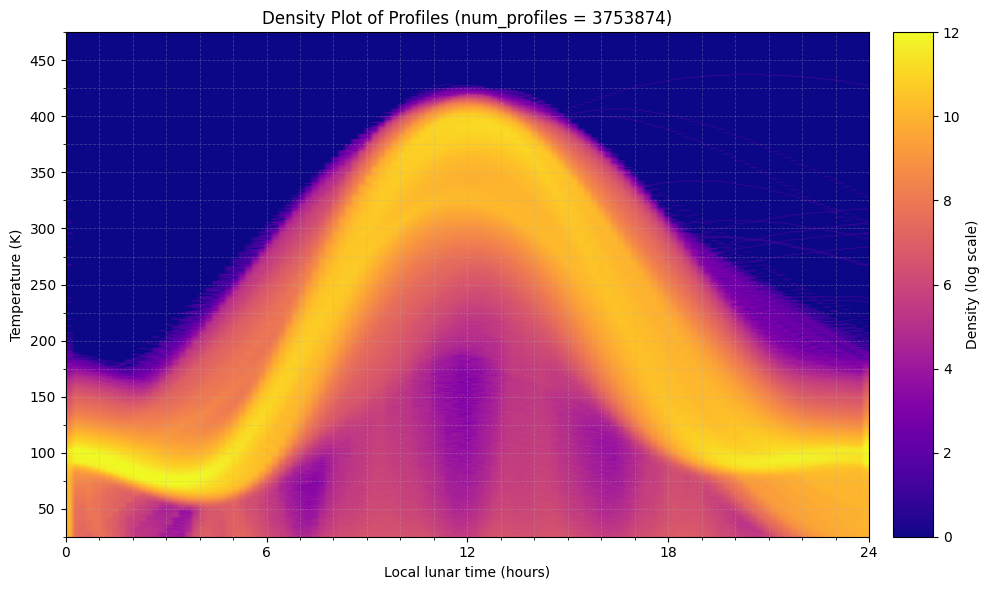

In [4]:
# * * * * * * * * * * * * * * * *
# Generate Density Plot
# * * * * * * * * * * * * * * * *
GenerateDensityPlot(temp_data, model_dir)

Saved figure to /workspace/outputs/profiles_v1_experiment_1_20250324_0053/histogram_max_temp.png


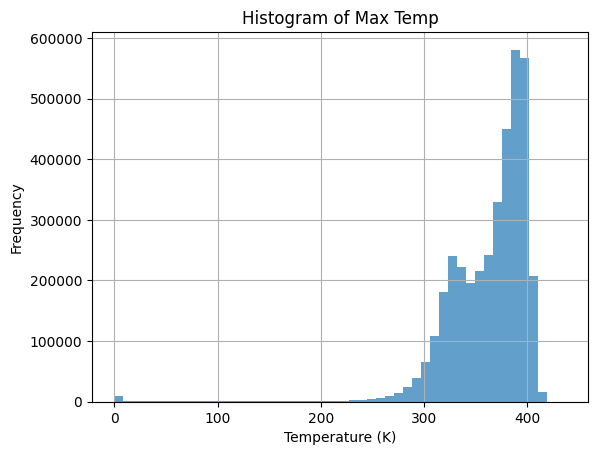

Saved figure to /workspace/outputs/profiles_v1_experiment_1_20250324_0053/histogram_min_temp.png


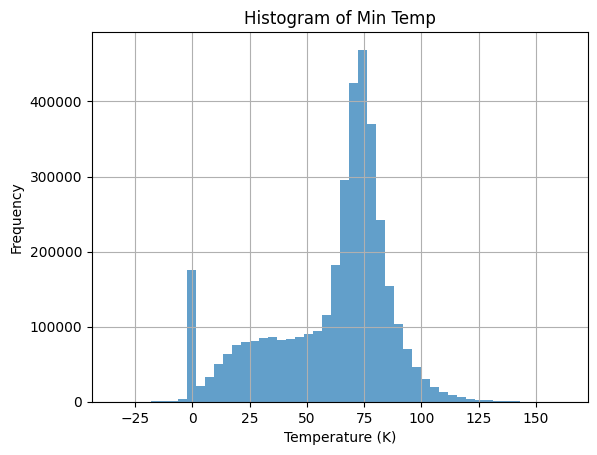

Saved figure to /workspace/outputs/profiles_v1_experiment_1_20250324_0053/histogram_mean_temp.png


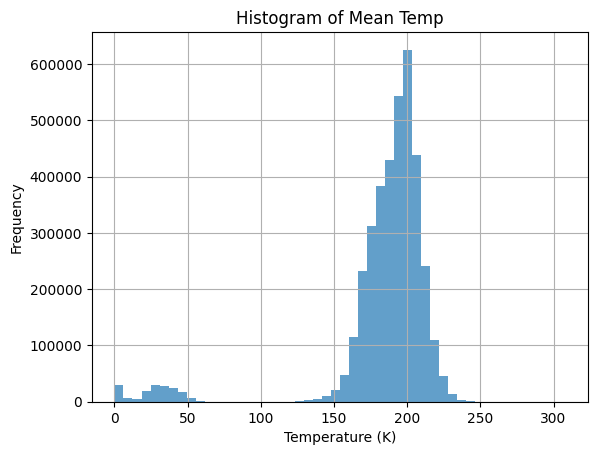

Saved figure to /workspace/outputs/profiles_v1_experiment_1_20250324_0053/histogram_std_temp.png


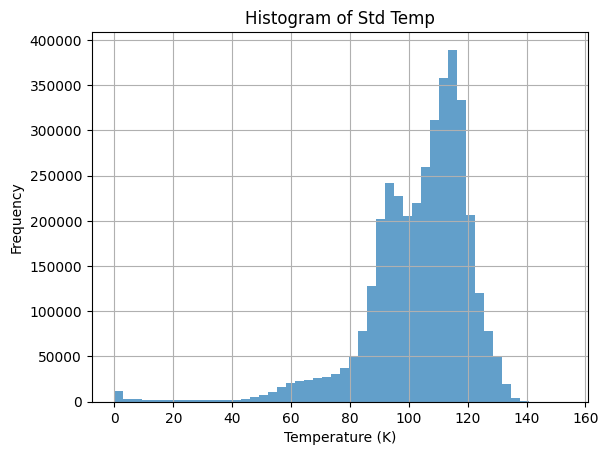

In [5]:
# * * * * * * * * * * * * * * * *
# Generate Histograms
# * * * * * * * * * * * * * * * *
profile_list = LoadProfileList(PROFILE_LIST_JSON)
statistics = CollectStatisticsFromProfilesV1(PROFILES_DIR, profile_list)
PlotHistograms(statistics, output_dir=model_dir)

In [6]:
# * * * * * * * * * * * * * * * *
# Training Log
# * * * * * * * * * * * * * * * 
log_filepath = os.path.join(model_dir, 'training.log')

# * * * * * * * * * * * * * * * *
# Data Prep
# * * * * * * * * * * * * * * * *
x_data_mean, x_data_std, x_data_min, x_data_max = GetDataMetrics(temp_data)

PrintAndLog(log_filepath, "Data Metrics:\n")
PrintAndLog(log_filepath, f"\tMean: {x_data_mean:.4f}\n")
PrintAndLog(log_filepath, f"\tSTD: {x_data_std:.4f}\n")
PrintAndLog(log_filepath, f"\tMin Temp: {x_data_min:.4f}\n")
PrintAndLog(log_filepath, f"\tMax Temp: {x_data_max:.4f}\n")

# Normalize Data (Mean=0, STD=1)
scaler = StandardScaler()
train_loader, val_loader, test_loader = SplitAndNormalizeData(
	temp_data, scaler, BATCH_SIZE, DEVICE)

PrintAndLog(log_filepath, "Datasets:\n")
PrintAndLog(
	log_filepath,
	f"\tTraining Data: {len(train_loader.dataset)}\n")
PrintAndLog(
	log_filepath,
	f"\tValidation Data: {len(val_loader.dataset)}\n")
PrintAndLog(log_filepath, f"\tTest Data: {len(test_loader.dataset)}\n")

Data Metrics:
Mean: 184.6054
STD: 111.5311
Min Temp: -33.9330
Max Temp: 437.1040
Datasets:
Training Data: 2627711
Validation Data: 750774
Test Data: 375389


In [7]:
# * * * * * * * * * * * * * * * *
# VAE Setup
# * * * * * * * * * * * * * * * *
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=GAMMA)

summary(vae, input_size=(BATCH_SIZE, INPUT_DIM[0], INPUT_DIM[1]))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [200, 1, 120]             --
├─Encoder: 1-1                           [200, 4, 1]               --
│    └─Wrap1d: 2-1                       [200, 1, 122]             --
│    └─ConstantPad1d: 2-2                [200, 1, 128]             --
│    └─Conv1d: 2-3                       [200, 32, 128]            128
│    └─BatchNorm1d: 2-4                  [200, 32, 128]            64
│    └─Conv1d: 2-5                       [200, 32, 64]             2,080
│    └─BatchNorm1d: 2-6                  [200, 32, 64]             64
│    └─Conv1d: 2-7                       [200, 32, 32]             2,080
│    └─BatchNorm1d: 2-8                  [200, 32, 32]             64
│    └─Conv1d: 2-9                       [200, 32, 16]             2,080
│    └─BatchNorm1d: 2-10                 [200, 32, 16]             64
│    └─Conv1d: 2-11                      [200, 32, 8]              2,080
│ 

[Training] Epoch 1/100: 100%|██████████| 13139/13139 [07:22<00:00, 29.68it/s, best_loss=0.4741]


[Training] Epoch 1/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.001000


[Validation] Epoch 1/100: 100%|██████████| 3754/3754 [00:39<00:00, 95.18it/s] 


[Validation] Epoch 1/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_1_20250324_0053'


[Training] Epoch 2/100: 100%|██████████| 13139/13139 [07:22<00:00, 29.69it/s, best_loss=0.4621]


[Training] Epoch 2/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000100


[Validation] Epoch 2/100: 100%|██████████| 3754/3754 [00:37<00:00, 100.38it/s]


[Validation] Epoch 2/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 3/100: 100%|██████████| 13139/13139 [06:43<00:00, 32.56it/s, best_loss=0.4605]


[Training] Epoch 3/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000010


[Validation] Epoch 3/100: 100%|██████████| 3754/3754 [00:31<00:00, 119.20it/s]


[Validation] Epoch 3/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 4/100: 100%|██████████| 13139/13139 [06:40<00:00, 32.85it/s, best_loss=0.4867]


[Training] Epoch 4/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000001


[Validation] Epoch 4/100: 100%|██████████| 3754/3754 [00:30<00:00, 121.94it/s]


[Validation] Epoch 4/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 5/100: 100%|██████████| 13139/13139 [06:47<00:00, 32.25it/s, best_loss=0.4917]


[Training] Epoch 5/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 5/100: 100%|██████████| 3754/3754 [00:31<00:00, 117.55it/s]


[Validation] Epoch 5/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 6/100: 100%|██████████| 13139/13139 [06:41<00:00, 32.70it/s, best_loss=0.4811]


[Training] Epoch 6/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 6/100: 100%|██████████| 3754/3754 [00:30<00:00, 124.86it/s]


[Validation] Epoch 6/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 7/100: 100%|██████████| 13139/13139 [06:37<00:00, 33.09it/s, best_loss=0.4328]


[Training] Epoch 7/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 7/100: 100%|██████████| 3754/3754 [00:30<00:00, 123.37it/s]


[Validation] Epoch 7/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 8/100: 100%|██████████| 13139/13139 [06:32<00:00, 33.51it/s, best_loss=0.5030]


[Training] Epoch 8/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 8/100: 100%|██████████| 3754/3754 [00:30<00:00, 124.64it/s]


[Validation] Epoch 8/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 9/100: 100%|██████████| 13139/13139 [06:27<00:00, 33.89it/s, best_loss=0.4572]


[Training] Epoch 9/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 9/100: 100%|██████████| 3754/3754 [00:30<00:00, 125.08it/s]


[Validation] Epoch 9/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 10/100: 100%|██████████| 13139/13139 [06:26<00:00, 33.97it/s, best_loss=0.4626]


[Training] Epoch 10/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 10/100: 100%|██████████| 3754/3754 [00:30<00:00, 123.06it/s]


[Validation] Epoch 10/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 11/100: 100%|██████████| 13139/13139 [06:46<00:00, 32.35it/s, best_loss=0.4967]


[Training] Epoch 11/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 11/100: 100%|██████████| 3754/3754 [00:38<00:00, 97.30it/s] 


[Validation] Epoch 11/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 12/100: 100%|██████████| 13139/13139 [07:23<00:00, 29.66it/s, best_loss=0.4137]


[Training] Epoch 12/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 12/100: 100%|██████████| 3754/3754 [00:39<00:00, 95.50it/s] 


[Validation] Epoch 12/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 13/100: 100%|██████████| 13139/13139 [07:25<00:00, 29.49it/s, best_loss=0.4880]


[Training] Epoch 13/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 13/100: 100%|██████████| 3754/3754 [00:39<00:00, 94.55it/s] 


[Validation] Epoch 13/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 14/100: 100%|██████████| 13139/13139 [07:24<00:00, 29.53it/s, best_loss=0.4885]


[Training] Epoch 14/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 14/100: 100%|██████████| 3754/3754 [00:38<00:00, 97.54it/s] 


[Validation] Epoch 14/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 15/100: 100%|██████████| 13139/13139 [07:30<00:00, 29.17it/s, best_loss=0.4269]


[Training] Epoch 15/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 15/100: 100%|██████████| 3754/3754 [00:34<00:00, 110.03it/s]


[Validation] Epoch 15/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 16/100: 100%|██████████| 13139/13139 [06:40<00:00, 32.82it/s, best_loss=0.4399]


[Training] Epoch 16/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 16/100: 100%|██████████| 3754/3754 [00:29<00:00, 125.87it/s]


[Validation] Epoch 16/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 17/100: 100%|██████████| 13139/13139 [06:37<00:00, 33.04it/s, best_loss=0.4887]


[Training] Epoch 17/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 17/100: 100%|██████████| 3754/3754 [00:29<00:00, 125.98it/s]


[Validation] Epoch 17/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 18/100: 100%|██████████| 13139/13139 [06:36<00:00, 33.10it/s, best_loss=0.4672]


[Training] Epoch 18/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 18/100: 100%|██████████| 3754/3754 [00:29<00:00, 125.93it/s]


[Validation] Epoch 18/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 19/100: 100%|██████████| 13139/13139 [06:36<00:00, 33.11it/s, best_loss=0.4539]


[Training] Epoch 19/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 19/100: 100%|██████████| 3754/3754 [00:29<00:00, 125.36it/s]


[Validation] Epoch 19/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 20/100: 100%|██████████| 13139/13139 [06:38<00:00, 32.97it/s, best_loss=0.4779]


[Training] Epoch 20/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 20/100: 100%|██████████| 3754/3754 [00:29<00:00, 125.52it/s]


[Validation] Epoch 20/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 21/100: 100%|██████████| 13139/13139 [06:38<00:00, 32.98it/s, best_loss=0.4582]


[Training] Epoch 21/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 21/100: 100%|██████████| 3754/3754 [00:30<00:00, 124.85it/s]


[Validation] Epoch 21/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 22/100: 100%|██████████| 13139/13139 [06:37<00:00, 33.02it/s, best_loss=0.4848]


[Training] Epoch 22/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 22/100: 100%|██████████| 3754/3754 [00:29<00:00, 126.20it/s]


[Validation] Epoch 22/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 23/100: 100%|██████████| 13139/13139 [06:41<00:00, 32.75it/s, best_loss=0.4690]


[Training] Epoch 23/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 23/100: 100%|██████████| 3754/3754 [00:35<00:00, 105.93it/s]


[Validation] Epoch 23/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 24/100: 100%|██████████| 13139/13139 [07:09<00:00, 30.63it/s, best_loss=0.4481]


[Training] Epoch 24/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 24/100: 100%|██████████| 3754/3754 [00:35<00:00, 106.06it/s]


[Validation] Epoch 24/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 25/100: 100%|██████████| 13139/13139 [07:08<00:00, 30.63it/s, best_loss=0.4131]


[Training] Epoch 25/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 25/100: 100%|██████████| 3754/3754 [00:35<00:00, 107.09it/s]


[Validation] Epoch 25/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 26/100: 100%|██████████| 13139/13139 [07:09<00:00, 30.60it/s, best_loss=0.4839]


[Training] Epoch 26/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 26/100: 100%|██████████| 3754/3754 [00:34<00:00, 108.68it/s]


[Validation] Epoch 26/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 27/100: 100%|██████████| 13139/13139 [07:09<00:00, 30.58it/s, best_loss=0.4314]


[Training] Epoch 27/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 27/100: 100%|██████████| 3754/3754 [00:34<00:00, 107.31it/s]


[Validation] Epoch 27/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 28/100: 100%|██████████| 13139/13139 [07:09<00:00, 30.59it/s, best_loss=0.4711]


[Training] Epoch 28/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 28/100: 100%|██████████| 3754/3754 [00:34<00:00, 108.96it/s]


[Validation] Epoch 28/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 29/100: 100%|██████████| 13139/13139 [07:01<00:00, 31.18it/s, best_loss=0.4540]


[Training] Epoch 29/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 29/100: 100%|██████████| 3754/3754 [00:34<00:00, 107.26it/s]


[Validation] Epoch 29/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 30/100: 100%|██████████| 13139/13139 [07:00<00:00, 31.25it/s, best_loss=0.5041]


[Training] Epoch 30/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 30/100: 100%|██████████| 3754/3754 [00:34<00:00, 107.41it/s]


[Validation] Epoch 30/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 31/100: 100%|██████████| 13139/13139 [07:00<00:00, 31.23it/s, best_loss=0.4807]


[Training] Epoch 31/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 31/100: 100%|██████████| 3754/3754 [00:34<00:00, 108.04it/s]


[Validation] Epoch 31/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 32/100: 100%|██████████| 13139/13139 [07:04<00:00, 30.95it/s, best_loss=0.4810]


[Training] Epoch 32/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 32/100: 100%|██████████| 3754/3754 [00:34<00:00, 108.85it/s]


[Validation] Epoch 32/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 33/100: 100%|██████████| 13139/13139 [07:06<00:00, 30.81it/s, best_loss=0.4285]


[Training] Epoch 33/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 33/100: 100%|██████████| 3754/3754 [00:35<00:00, 107.03it/s]


[Validation] Epoch 33/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 34/100: 100%|██████████| 13139/13139 [07:10<00:00, 30.55it/s, best_loss=0.4601]


[Training] Epoch 34/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 34/100: 100%|██████████| 3754/3754 [00:35<00:00, 105.25it/s]


[Validation] Epoch 34/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 35/100: 100%|██████████| 13139/13139 [07:09<00:00, 30.60it/s, best_loss=0.4429]


[Training] Epoch 35/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 35/100: 100%|██████████| 3754/3754 [00:35<00:00, 104.46it/s]


[Validation] Epoch 35/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 36/100: 100%|██████████| 13139/13139 [07:10<00:00, 30.52it/s, best_loss=0.4898]


[Training] Epoch 36/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 36/100: 100%|██████████| 3754/3754 [00:35<00:00, 107.15it/s]


[Validation] Epoch 36/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 37/100: 100%|██████████| 13139/13139 [07:09<00:00, 30.61it/s, best_loss=0.5026]


[Training] Epoch 37/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 37/100: 100%|██████████| 3754/3754 [00:34<00:00, 108.04it/s]


[Validation] Epoch 37/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 38/100: 100%|██████████| 13139/13139 [07:09<00:00, 30.56it/s, best_loss=0.4798]


[Training] Epoch 38/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 38/100: 100%|██████████| 3754/3754 [00:34<00:00, 107.74it/s]


[Validation] Epoch 38/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 39/100: 100%|██████████| 13139/13139 [07:10<00:00, 30.53it/s, best_loss=0.4468]


[Training] Epoch 39/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 39/100: 100%|██████████| 3754/3754 [00:35<00:00, 106.93it/s]


[Validation] Epoch 39/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 40/100: 100%|██████████| 13139/13139 [07:08<00:00, 30.65it/s, best_loss=0.4883]


[Training] Epoch 40/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 40/100: 100%|██████████| 3754/3754 [00:34<00:00, 109.86it/s]


[Validation] Epoch 40/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 41/100: 100%|██████████| 13139/13139 [07:03<00:00, 31.05it/s, best_loss=0.4256]


[Training] Epoch 41/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 41/100: 100%|██████████| 3754/3754 [00:33<00:00, 111.44it/s]


[Validation] Epoch 41/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 42/100: 100%|██████████| 13139/13139 [07:03<00:00, 31.04it/s, best_loss=0.4499]


[Training] Epoch 42/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 42/100: 100%|██████████| 3754/3754 [00:34<00:00, 109.71it/s]


[Validation] Epoch 42/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 43/100: 100%|██████████| 13139/13139 [07:06<00:00, 30.80it/s, best_loss=0.4598]


[Training] Epoch 43/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 43/100: 100%|██████████| 3754/3754 [00:33<00:00, 113.67it/s]


[Validation] Epoch 43/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 44/100: 100%|██████████| 13139/13139 [07:04<00:00, 30.97it/s, best_loss=0.4918]


[Training] Epoch 44/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 44/100: 100%|██████████| 3754/3754 [00:33<00:00, 111.46it/s]


[Validation] Epoch 44/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 45/100: 100%|██████████| 13139/13139 [07:02<00:00, 31.07it/s, best_loss=0.4772]


[Training] Epoch 45/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 45/100: 100%|██████████| 3754/3754 [00:34<00:00, 108.79it/s]


[Validation] Epoch 45/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 46/100: 100%|██████████| 13139/13139 [07:04<00:00, 30.95it/s, best_loss=0.4948]


[Training] Epoch 46/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 46/100: 100%|██████████| 3754/3754 [00:34<00:00, 108.60it/s]


[Validation] Epoch 46/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 47/100: 100%|██████████| 13139/13139 [07:02<00:00, 31.13it/s, best_loss=0.4315]


[Training] Epoch 47/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 47/100: 100%|██████████| 3754/3754 [00:34<00:00, 110.40it/s]


[Validation] Epoch 47/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 48/100: 100%|██████████| 13139/13139 [07:04<00:00, 30.97it/s, best_loss=0.5130]


[Training] Epoch 48/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 48/100: 100%|██████████| 3754/3754 [00:34<00:00, 110.06it/s]


[Validation] Epoch 48/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 49/100: 100%|██████████| 13139/13139 [07:03<00:00, 31.01it/s, best_loss=0.4576]


[Training] Epoch 49/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 49/100: 100%|██████████| 3754/3754 [00:34<00:00, 107.28it/s]


[Validation] Epoch 49/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 50/100: 100%|██████████| 13139/13139 [07:02<00:00, 31.06it/s, best_loss=0.4650]


[Training] Epoch 50/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 50/100: 100%|██████████| 3754/3754 [00:34<00:00, 108.62it/s]


[Validation] Epoch 50/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 51/100: 100%|██████████| 13139/13139 [07:03<00:00, 31.01it/s, best_loss=0.4962]


[Training] Epoch 51/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 51/100: 100%|██████████| 3754/3754 [00:34<00:00, 108.42it/s]


[Validation] Epoch 51/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 52/100: 100%|██████████| 13139/13139 [07:03<00:00, 31.05it/s, best_loss=0.4055]


[Training] Epoch 52/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 52/100: 100%|██████████| 3754/3754 [00:33<00:00, 112.99it/s]


[Validation] Epoch 52/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 53/100: 100%|██████████| 13139/13139 [07:05<00:00, 30.89it/s, best_loss=0.4965]


[Training] Epoch 53/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 53/100: 100%|██████████| 3754/3754 [00:34<00:00, 108.79it/s]


[Validation] Epoch 53/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 54/100: 100%|██████████| 13139/13139 [07:06<00:00, 30.81it/s, best_loss=0.4901]


[Training] Epoch 54/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 54/100: 100%|██████████| 3754/3754 [00:34<00:00, 109.91it/s]


[Validation] Epoch 54/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 55/100: 100%|██████████| 13139/13139 [07:04<00:00, 30.92it/s, best_loss=0.4975]


[Training] Epoch 55/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 55/100: 100%|██████████| 3754/3754 [00:33<00:00, 110.80it/s]


[Validation] Epoch 55/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 56/100: 100%|██████████| 13139/13139 [07:04<00:00, 30.93it/s, best_loss=0.5060]


[Training] Epoch 56/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 56/100: 100%|██████████| 3754/3754 [00:34<00:00, 107.34it/s]


[Validation] Epoch 56/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 57/100: 100%|██████████| 13139/13139 [07:04<00:00, 30.97it/s, best_loss=0.4635]


[Training] Epoch 57/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 57/100: 100%|██████████| 3754/3754 [00:33<00:00, 111.11it/s]


[Validation] Epoch 57/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 58/100: 100%|██████████| 13139/13139 [07:02<00:00, 31.07it/s, best_loss=0.4890]


[Training] Epoch 58/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 58/100: 100%|██████████| 3754/3754 [00:34<00:00, 110.19it/s]


[Validation] Epoch 58/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 59/100: 100%|██████████| 13139/13139 [06:58<00:00, 31.41it/s, best_loss=0.4448]


[Training] Epoch 59/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 59/100: 100%|██████████| 3754/3754 [00:34<00:00, 108.75it/s]


[Validation] Epoch 59/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 60/100: 100%|██████████| 13139/13139 [06:58<00:00, 31.41it/s, best_loss=0.4077]


[Training] Epoch 60/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 60/100: 100%|██████████| 3754/3754 [00:34<00:00, 109.22it/s]


[Validation] Epoch 60/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 61/100: 100%|██████████| 13139/13139 [07:00<00:00, 31.27it/s, best_loss=0.4465]


[Training] Epoch 61/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 61/100: 100%|██████████| 3754/3754 [00:35<00:00, 106.87it/s]


[Validation] Epoch 61/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 62/100: 100%|██████████| 13139/13139 [07:05<00:00, 30.91it/s, best_loss=0.4636]


[Training] Epoch 62/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 62/100: 100%|██████████| 3754/3754 [00:33<00:00, 110.47it/s]


[Validation] Epoch 62/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 63/100: 100%|██████████| 13139/13139 [07:05<00:00, 30.86it/s, best_loss=0.4573]


[Training] Epoch 63/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 63/100: 100%|██████████| 3754/3754 [00:34<00:00, 109.58it/s]


[Validation] Epoch 63/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 64/100: 100%|██████████| 13139/13139 [07:06<00:00, 30.80it/s, best_loss=0.4966]


[Training] Epoch 64/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 64/100: 100%|██████████| 3754/3754 [00:34<00:00, 108.31it/s]


[Validation] Epoch 64/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 65/100: 100%|██████████| 13139/13139 [07:05<00:00, 30.87it/s, best_loss=0.5046]


[Training] Epoch 65/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 65/100: 100%|██████████| 3754/3754 [00:34<00:00, 108.49it/s]


[Validation] Epoch 65/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 66/100: 100%|██████████| 13139/13139 [07:05<00:00, 30.87it/s, best_loss=0.4231]


[Training] Epoch 66/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 66/100: 100%|██████████| 3754/3754 [00:34<00:00, 109.46it/s]


[Validation] Epoch 66/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 67/100: 100%|██████████| 13139/13139 [07:06<00:00, 30.84it/s, best_loss=0.4771]


[Training] Epoch 67/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 67/100: 100%|██████████| 3754/3754 [00:34<00:00, 109.13it/s]


[Validation] Epoch 67/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 68/100: 100%|██████████| 13139/13139 [07:03<00:00, 30.99it/s, best_loss=0.4820]


[Training] Epoch 68/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 68/100: 100%|██████████| 3754/3754 [00:34<00:00, 108.93it/s]


[Validation] Epoch 68/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 69/100: 100%|██████████| 13139/13139 [07:05<00:00, 30.85it/s, best_loss=0.4681]


[Training] Epoch 69/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 69/100: 100%|██████████| 3754/3754 [00:35<00:00, 106.96it/s]


[Validation] Epoch 69/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 70/100: 100%|██████████| 13139/13139 [07:05<00:00, 30.87it/s, best_loss=0.4813]


[Training] Epoch 70/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 70/100: 100%|██████████| 3754/3754 [00:34<00:00, 108.99it/s]


[Validation] Epoch 70/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 71/100: 100%|██████████| 13139/13139 [07:05<00:00, 30.87it/s, best_loss=0.4963]


[Training] Epoch 71/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 71/100: 100%|██████████| 3754/3754 [00:34<00:00, 110.38it/s]


[Validation] Epoch 71/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 72/100: 100%|██████████| 13139/13139 [07:07<00:00, 30.76it/s, best_loss=0.4173]


[Training] Epoch 72/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 72/100: 100%|██████████| 3754/3754 [00:34<00:00, 108.78it/s]


[Validation] Epoch 72/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 73/100: 100%|██████████| 13139/13139 [07:07<00:00, 30.74it/s, best_loss=0.4781]


[Training] Epoch 73/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 73/100: 100%|██████████| 3754/3754 [00:34<00:00, 108.25it/s]


[Validation] Epoch 73/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 74/100: 100%|██████████| 13139/13139 [07:06<00:00, 30.81it/s, best_loss=0.4779]


[Training] Epoch 74/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 74/100: 100%|██████████| 3754/3754 [00:34<00:00, 107.70it/s]


[Validation] Epoch 74/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 75/100: 100%|██████████| 13139/13139 [07:08<00:00, 30.69it/s, best_loss=0.4611]


[Training] Epoch 75/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 75/100: 100%|██████████| 3754/3754 [00:33<00:00, 110.78it/s]


[Validation] Epoch 75/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 76/100: 100%|██████████| 13139/13139 [07:07<00:00, 30.75it/s, best_loss=0.4811]


[Training] Epoch 76/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 76/100: 100%|██████████| 3754/3754 [00:34<00:00, 108.31it/s]


[Validation] Epoch 76/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 77/100: 100%|██████████| 13139/13139 [07:07<00:00, 30.74it/s, best_loss=0.4907]


[Training] Epoch 77/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 77/100: 100%|██████████| 3754/3754 [00:34<00:00, 108.87it/s]


[Validation] Epoch 77/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 78/100: 100%|██████████| 13139/13139 [07:06<00:00, 30.81it/s, best_loss=0.4410]


[Training] Epoch 78/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 78/100: 100%|██████████| 3754/3754 [00:34<00:00, 109.86it/s]


[Validation] Epoch 78/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 79/100: 100%|██████████| 13139/13139 [07:09<00:00, 30.62it/s, best_loss=0.4940]


[Training] Epoch 79/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 79/100: 100%|██████████| 3754/3754 [00:34<00:00, 109.72it/s]


[Validation] Epoch 79/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 80/100: 100%|██████████| 13139/13139 [07:09<00:00, 30.61it/s, best_loss=0.4785]


[Training] Epoch 80/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 80/100: 100%|██████████| 3754/3754 [00:34<00:00, 109.35it/s]


[Validation] Epoch 80/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 81/100: 100%|██████████| 13139/13139 [07:08<00:00, 30.67it/s, best_loss=0.4899]


[Training] Epoch 81/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 81/100: 100%|██████████| 3754/3754 [00:34<00:00, 107.34it/s]


[Validation] Epoch 81/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 82/100: 100%|██████████| 13139/13139 [07:04<00:00, 30.92it/s, best_loss=0.5009]


[Training] Epoch 82/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 82/100: 100%|██████████| 3754/3754 [00:34<00:00, 107.76it/s]


[Validation] Epoch 82/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 83/100: 100%|██████████| 13139/13139 [07:09<00:00, 30.56it/s, best_loss=0.4639]


[Training] Epoch 83/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 83/100: 100%|██████████| 3754/3754 [00:33<00:00, 110.85it/s]


[Validation] Epoch 83/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 84/100: 100%|██████████| 13139/13139 [07:07<00:00, 30.76it/s, best_loss=0.4885]


[Training] Epoch 84/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 84/100: 100%|██████████| 3754/3754 [00:35<00:00, 106.28it/s]


[Validation] Epoch 84/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 85/100: 100%|██████████| 13139/13139 [07:07<00:00, 30.71it/s, best_loss=0.4566]


[Training] Epoch 85/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 85/100: 100%|██████████| 3754/3754 [00:34<00:00, 109.67it/s]


[Validation] Epoch 85/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 86/100: 100%|██████████| 13139/13139 [07:06<00:00, 30.77it/s, best_loss=0.4972]


[Training] Epoch 86/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 86/100: 100%|██████████| 3754/3754 [00:34<00:00, 108.86it/s]


[Validation] Epoch 86/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 87/100: 100%|██████████| 13139/13139 [07:09<00:00, 30.58it/s, best_loss=0.4891]


[Training] Epoch 87/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 87/100: 100%|██████████| 3754/3754 [00:34<00:00, 109.73it/s]


[Validation] Epoch 87/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 88/100: 100%|██████████| 13139/13139 [07:08<00:00, 30.68it/s, best_loss=0.4264]


[Training] Epoch 88/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 88/100: 100%|██████████| 3754/3754 [00:35<00:00, 106.37it/s]


[Validation] Epoch 88/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 89/100: 100%|██████████| 13139/13139 [07:08<00:00, 30.65it/s, best_loss=0.5002]


[Training] Epoch 89/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 89/100: 100%|██████████| 3754/3754 [00:34<00:00, 109.92it/s]


[Validation] Epoch 89/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 90/100: 100%|██████████| 13139/13139 [07:10<00:00, 30.51it/s, best_loss=0.4638]


[Training] Epoch 90/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 90/100: 100%|██████████| 3754/3754 [00:34<00:00, 109.30it/s]


[Validation] Epoch 90/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 91/100: 100%|██████████| 13139/13139 [07:08<00:00, 30.67it/s, best_loss=0.4857]


[Training] Epoch 91/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 91/100: 100%|██████████| 3754/3754 [00:34<00:00, 108.37it/s]


[Validation] Epoch 91/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 92/100: 100%|██████████| 13139/13139 [07:09<00:00, 30.56it/s, best_loss=0.4845]


[Training] Epoch 92/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 92/100: 100%|██████████| 3754/3754 [00:34<00:00, 107.86it/s]


[Validation] Epoch 92/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 93/100: 100%|██████████| 13139/13139 [07:10<00:00, 30.51it/s, best_loss=0.4536]


[Training] Epoch 93/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 93/100: 100%|██████████| 3754/3754 [00:34<00:00, 108.80it/s]


[Validation] Epoch 93/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 94/100: 100%|██████████| 13139/13139 [07:09<00:00, 30.59it/s, best_loss=0.4740]


[Training] Epoch 94/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 94/100: 100%|██████████| 3754/3754 [00:35<00:00, 106.16it/s]


[Validation] Epoch 94/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 95/100: 100%|██████████| 13139/13139 [07:08<00:00, 30.67it/s, best_loss=0.4372]


[Training] Epoch 95/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 95/100: 100%|██████████| 3754/3754 [00:34<00:00, 108.78it/s]


[Validation] Epoch 95/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 96/100: 100%|██████████| 13139/13139 [07:10<00:00, 30.51it/s, best_loss=0.4723]


[Training] Epoch 96/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 96/100: 100%|██████████| 3754/3754 [00:35<00:00, 106.42it/s]


[Validation] Epoch 96/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 97/100: 100%|██████████| 13139/13139 [07:08<00:00, 30.65it/s, best_loss=0.4597]


[Training] Epoch 97/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 97/100: 100%|██████████| 3754/3754 [00:34<00:00, 107.54it/s]


[Validation] Epoch 97/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 98/100: 100%|██████████| 13139/13139 [07:08<00:00, 30.63it/s, best_loss=0.4675]


[Training] Epoch 98/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 98/100: 100%|██████████| 3754/3754 [00:35<00:00, 105.57it/s]


[Validation] Epoch 98/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 99/100: 100%|██████████| 13139/13139 [07:10<00:00, 30.50it/s, best_loss=0.4607]


[Training] Epoch 99/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 99/100: 100%|██████████| 3754/3754 [00:35<00:00, 106.45it/s]


[Validation] Epoch 99/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


[Training] Epoch 100/100: 100%|██████████| 13139/13139 [07:10<00:00, 30.54it/s, best_loss=0.4611]


[Training] Epoch 100/100, L1 Loss: 0.6505, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 100/100: 100%|██████████| 3754/3754 [00:34<00:00, 109.52it/s]


[Validation] Epoch 100/100, Val L1 Loss: 0.6508, Val L2 Loss: 1.0007, Val KL Loss: 0.0000


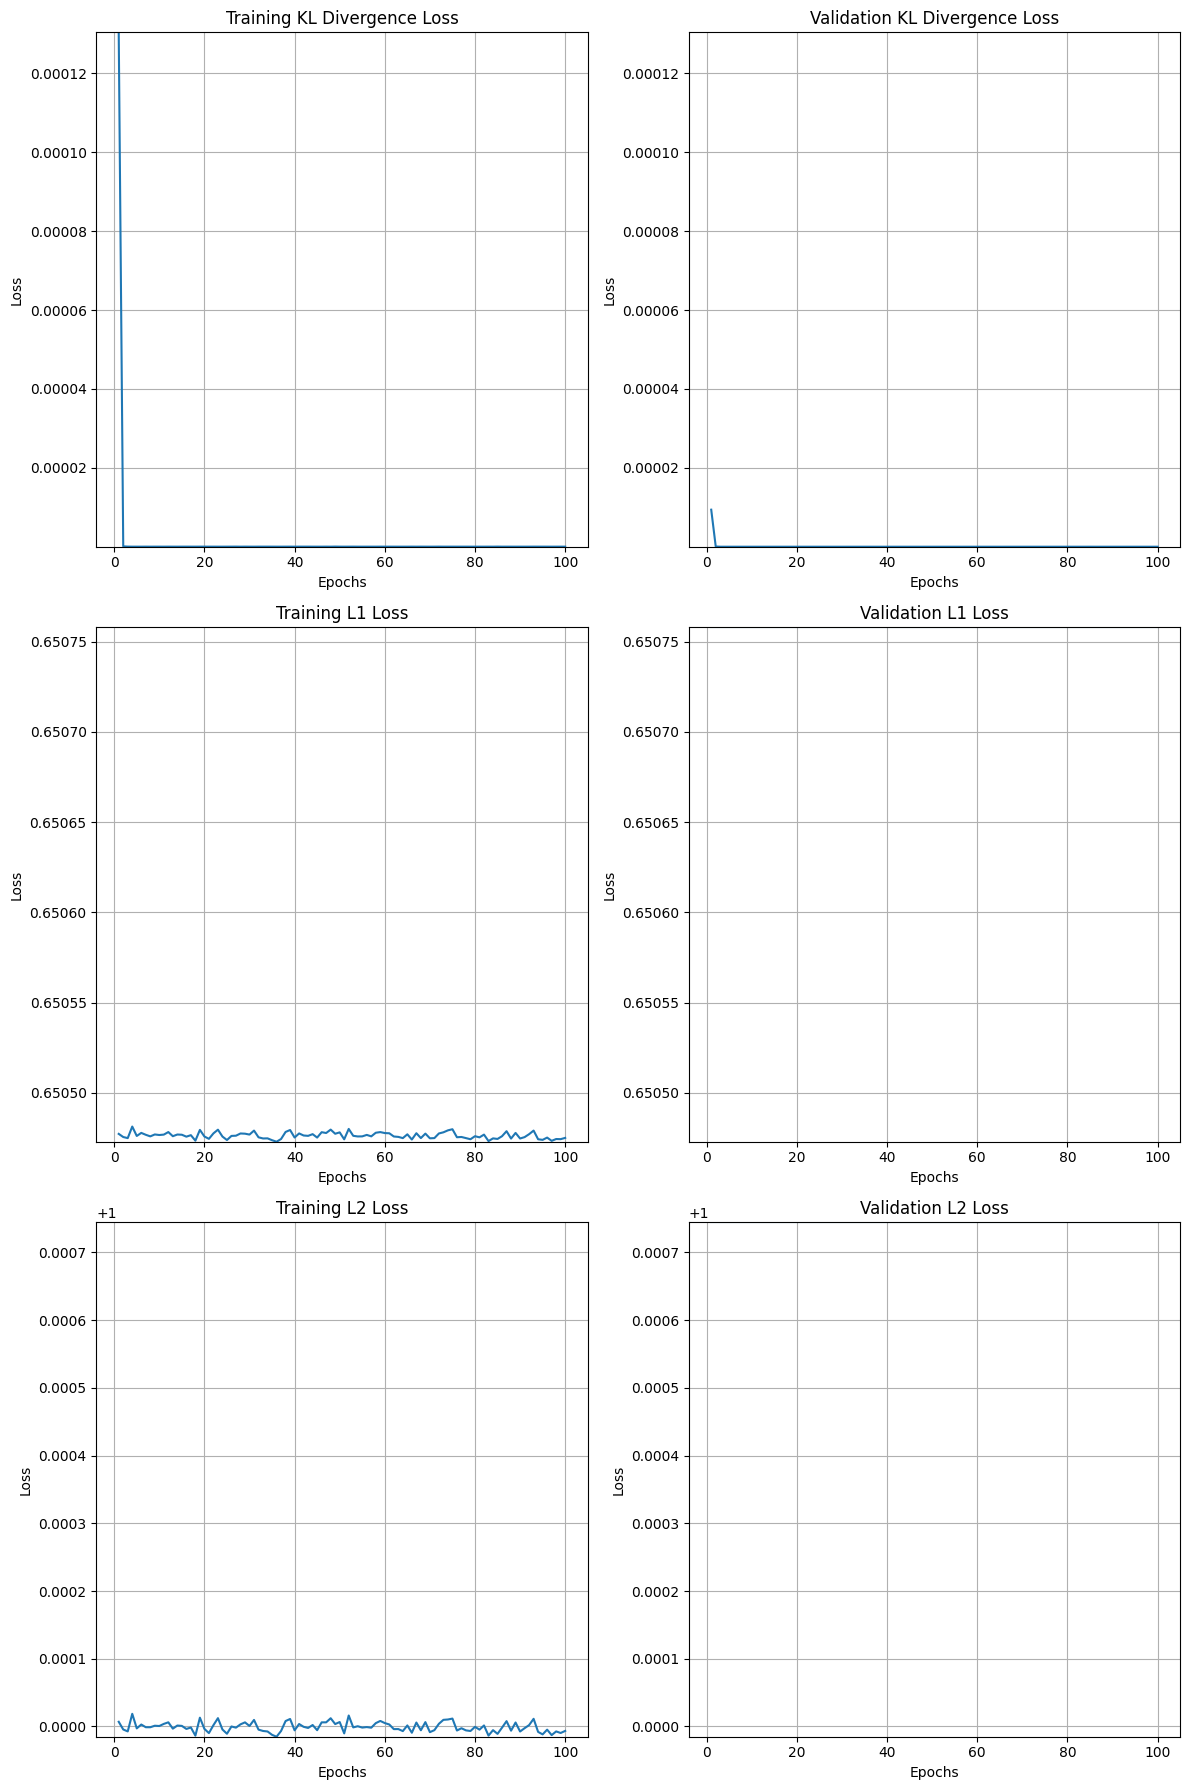

Best Validation Loss in Kelvins:
72.5798 K


In [8]:
# * * * * * * * * * * * * * * * *
# Train and Validate
# * * * * * * * * * * * * * * * *
losses = train(
	vae, train_loader, val_loader,
	optimizer, scheduler, DEVICE, EPOCHS,
	BETA, model_dir)

# Plot losses
PlotLosses(losses, EPOCHS, model_dir)

# Save losses
SaveLossesToCSV(losses, os.path.join(model_dir, "losses.csv"))

PrintAndLog(log_filepath, "Best Validation Loss in Kelvins:\n")
PrintAndLog(s
	log_filepath,
	f"\t{min(losses['val_l1_losses'])*x_data_std:.4f} K\n")

In [9]:
# * * * * * * * * * * * * * * * *
# Sample
# * * * * * * * * * * * * * * * *
z_sample = SampleLatentSpace(
	vae,
	test_loader,
	scaler,
	DEVICE,
	model_dir
)

[Sampling]: 100%|██████████| 188/188 [01:09<00:00,  2.71it/s]


z0: -0.0000
z1: -0.0000
z2: -0.0000
z3: 0.0000


Traversing Latent Dimension z3: 100%|██████████| 11/11 [00:00<00:00, 674.95it/s]


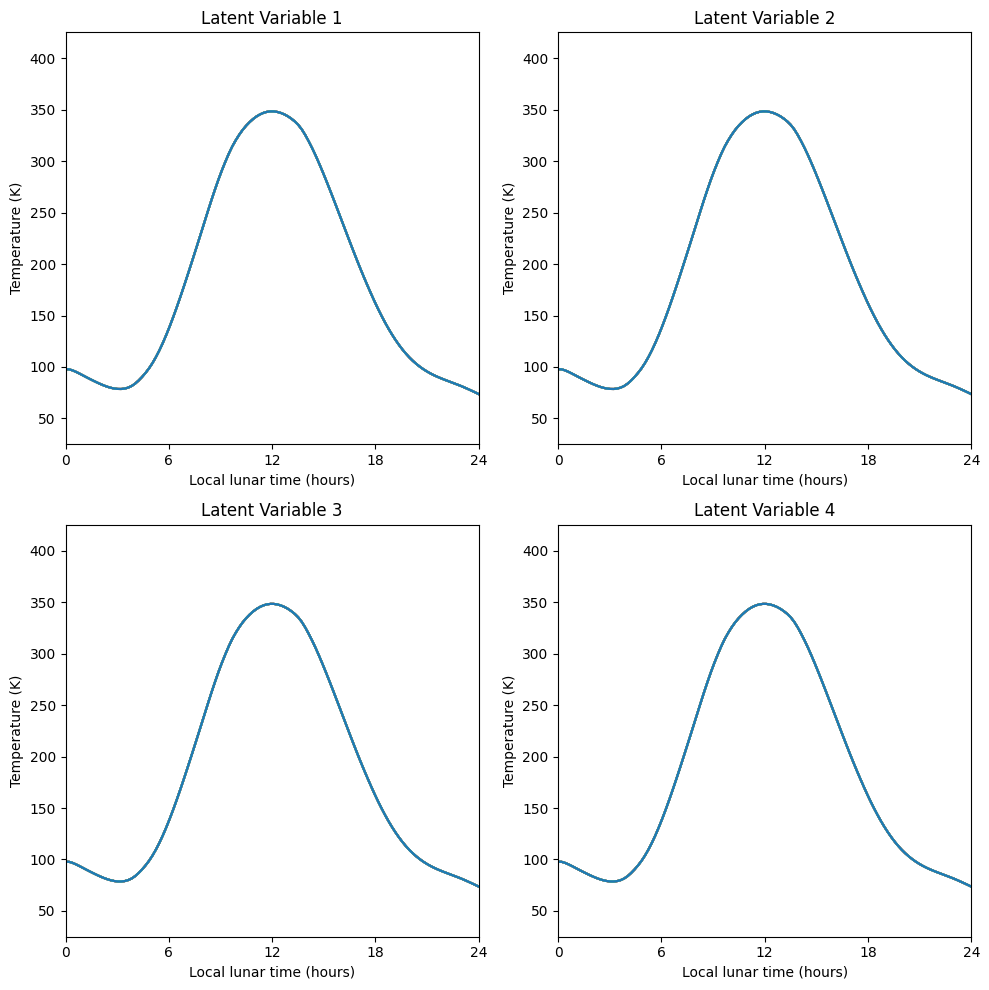

In [10]:
# * * * * * * * * * * * * * * * *
# Analyze Latent Space
# * * * * * * * * * * * * * * * *
mean_latent_vals = GetMeanLatentValues(z_sample, LATENT_DIM)
for i in range(LATENT_DIM):
	print(f"z{i}: {mean_latent_vals[i]:.4f}")

VisualizeLatentSpace(
	vae, LATENT_DIM, z_sample,
	scaler, DEVICE, model_dir)